# Question1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

class Dice:
    """Base class for a dice."""
    
    def roll(self):
        raise NotImplementedError("Subclasses should implement this!")

class FairDice(Dice):
    """Standard six-sided fair dice."""
    
    def roll(self):
        return np.random.randint(1, 7)

class WeightedDice(Dice):
    """Weighted dice with custom probabilities."""
    
    def __init__(self, probabilities):
        self.probabilities = probabilities
    
    def roll(self):
        return np.random.choice([1, 2, 3, 4, 5, 6], p=self.probabilities)

class Game:
    """Game logic for rolling dice and updating values based on epsilon-greedy strategy."""
    
    def __init__(self, epsilon, iterations, probabilities):
        self.epsilon = epsilon
        self.iterations = iterations
        self.values = np.zeros(6)
        self.counts = np.zeros(6)
        self.weighted_dice = WeightedDice(probabilities)
        self.fair_dice = FairDice()
    
    def throw_dice(self, values):
        if np.random.rand() < self.epsilon:
            return self.fair_dice.roll()
        else:
            return np.argmax(values) + 1
    
    def play(self):
        total_values = np.zeros((self.iterations, 6))
        for i in range(self.iterations):
            action = self.throw_dice(self.values) - 1
            reward = 1 if self.weighted_dice.roll() == action + 1 else 0
            self.counts[action] += 1
            self.values[action] += (reward - self.values[action]) / self.counts[action]
            total_values[i] = self.values.copy()
        return self.values, total_values

class Simulation:
    """Run the dice game simulation across different epsilon values and visualize results."""
    
    def __init__(self, epsilons, iterations, probabilities):
        self.epsilons = epsilons
        self.iterations = iterations
        self.probabilities = probabilities
        self.results = {}
    
    def run(self):
        for epsilon in self.epsilons:
            game = Game(epsilon, self.iterations, self.probabilities)
            values_final, total_values = game.play()
            self.results[epsilon] = {'Values': values_final, 'Total': total_values}
        self.plot_results()
    
    def plot_results(self):
        plt.figure(figsize=(14, 8))
        for epsilon, data in self.results.items():
            for action in range(6):
                plt.plot(data['Total'][:, action], label=f"ε={epsilon}, Action {action + 1}", alpha=0.8)
        plt.xlabel('iterations')
        plt.ylabel('Action Value')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

## epsilon = 1

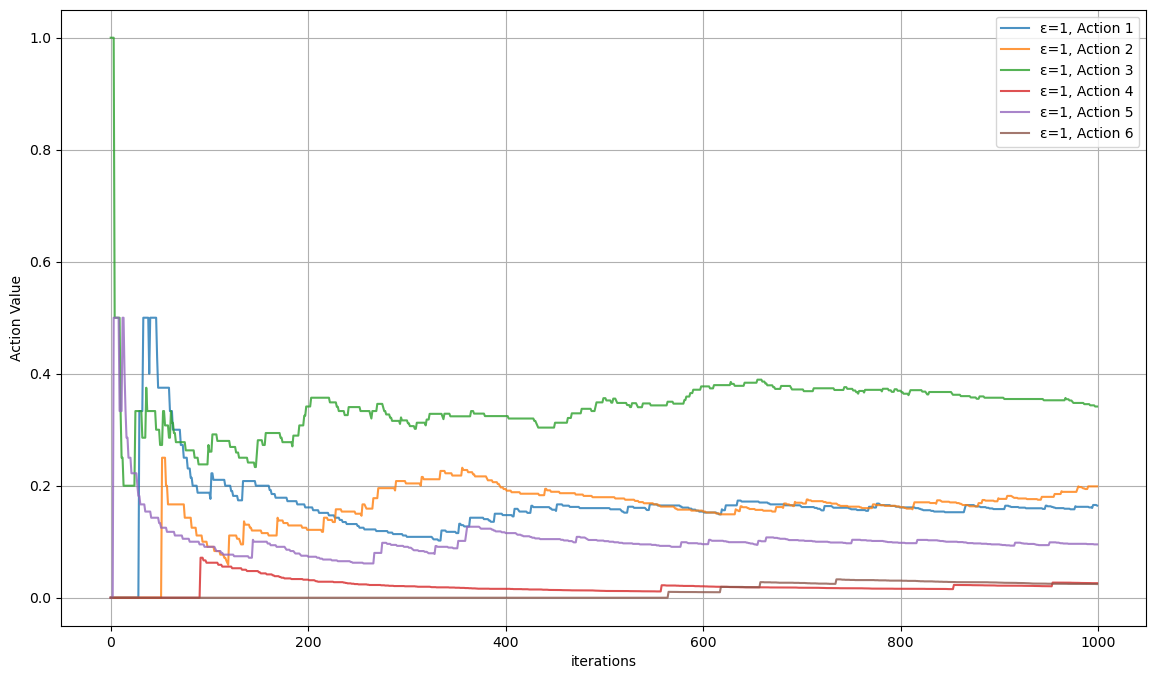

In [2]:
# Parameters
epsilons = [1]
iterations = 1000
probabilities = [0.20, 0.20, 0.37, 0.05, 0.12, 0.06]

# Run simulation
simulation = Simulation(epsilons, iterations, probabilities)
simulation.run()

## epsilon = 0.1

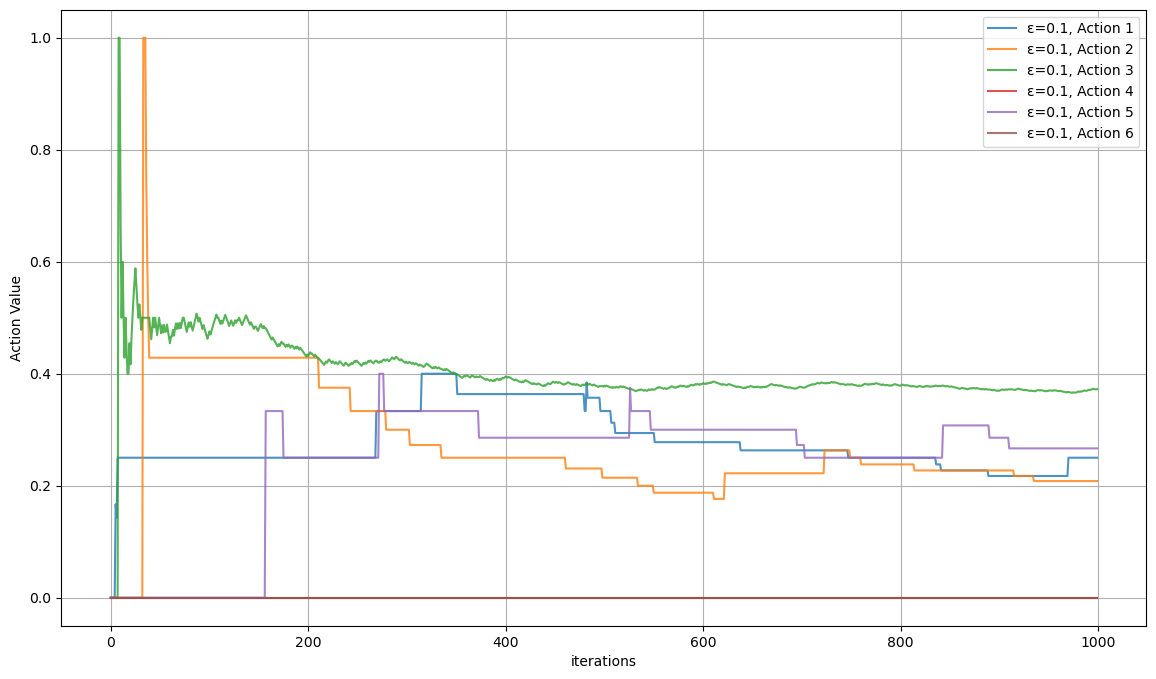

In [3]:
# Parameters
epsilons = [0.1]
iterations = 1000
probabilities = [0.20, 0.20, 0.37, 0.05, 0.12, 0.06]

# Run simulation
simulation = Simulation(epsilons, iterations, probabilities)
simulation.run()

## epsilon = 0.01

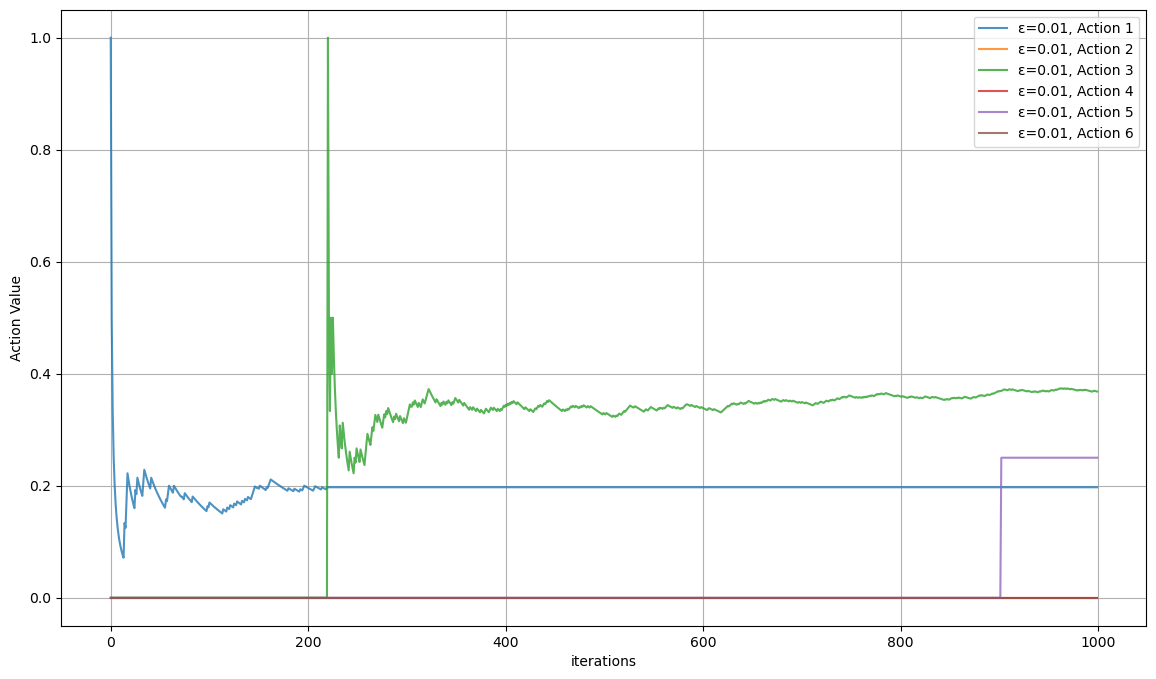

In [4]:
# Parameters
epsilons = [0.01]
iterations = 1000
probabilities = [0.20, 0.20, 0.37, 0.05, 0.12, 0.06]

# Run simulation
simulation = Simulation(epsilons, iterations, probabilities)
simulation.run()

# Question2

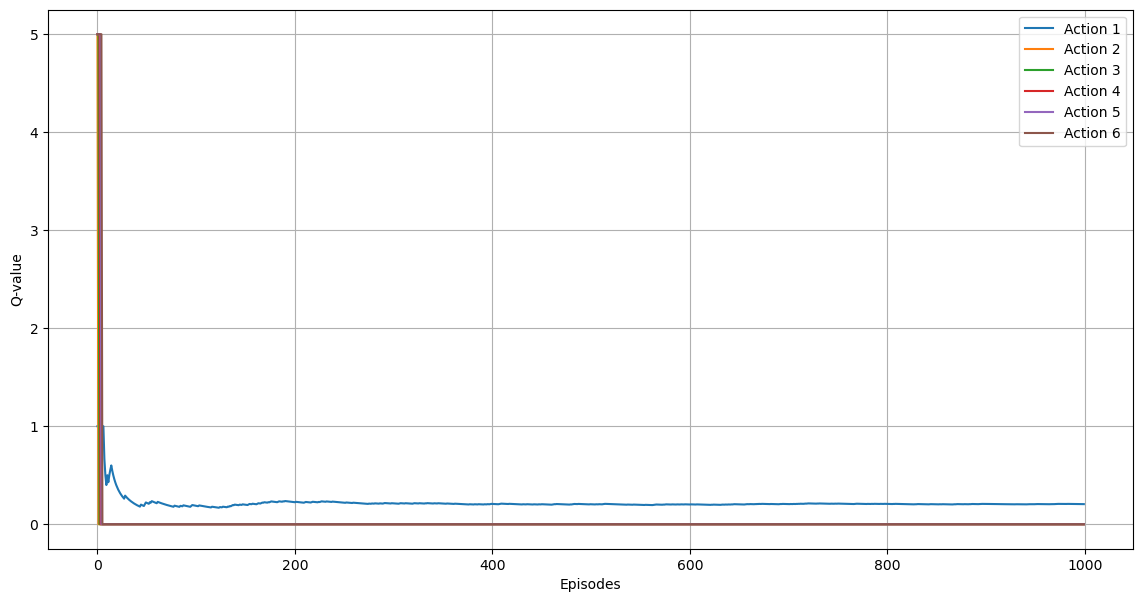

In [5]:
class BiasedDie:
    """Class representing a biased six-sided die."""
    def __init__(self, side_probabilities):
        self.side_probabilities = side_probabilities

    def roll(self):
        return np.random.choice([1, 2, 3, 4, 5, 6], p=self.side_probabilities)

class OptimisticGame:
    """Simulation of a game with optimistic initial values for action selection."""
    def __init__(self, die, episodes=1000, optimistic_value=5.0):
        self.die = die
        self.episodes = episodes
        self.optimistic_value = optimistic_value
        self.action_values = np.full(6, optimistic_value)  # Q-values initialized optimistically
        self.action_counts = np.zeros(6)
        self.action_value_history = np.zeros((episodes, 6))

    def run_simulation(self):
        for episode in range(self.episodes):
            chosen_action = np.argmax(self.action_values)  # Select action with highest Q-value
            actual_result = self.die.roll()
            reward = 1 if (chosen_action + 1) == actual_result else 0
            self.action_counts[chosen_action] += 1
            self.action_values[chosen_action] += (reward - self.action_values[chosen_action]) / self.action_counts[chosen_action]
            self.action_value_history[episode] = self.action_values.copy()
        return self.action_values, self.action_value_history

    def plot_action_values(self):
        plt.figure(figsize=(14, 7))
        for action in range(6):
            plt.plot(self.action_value_history[:, action], label=f'Action {action + 1}')
        plt.xlabel('Episodes')
        plt.ylabel('Q-value')
        plt.legend()
        plt.grid(True)
        plt.show()

# Define the probabilities for each side of the biased die
probabilities = [0.20, 0.20, 0.37, 0.05, 0.12, 0.06]
die = BiasedDie(probabilities)

# Create an instance of the game
optimistic_game = OptimisticGame(die)
final_values, value_history = optimistic_game.run_simulation()

# Plot the evolution of Q-values
optimistic_game.plot_action_values()

# Question3

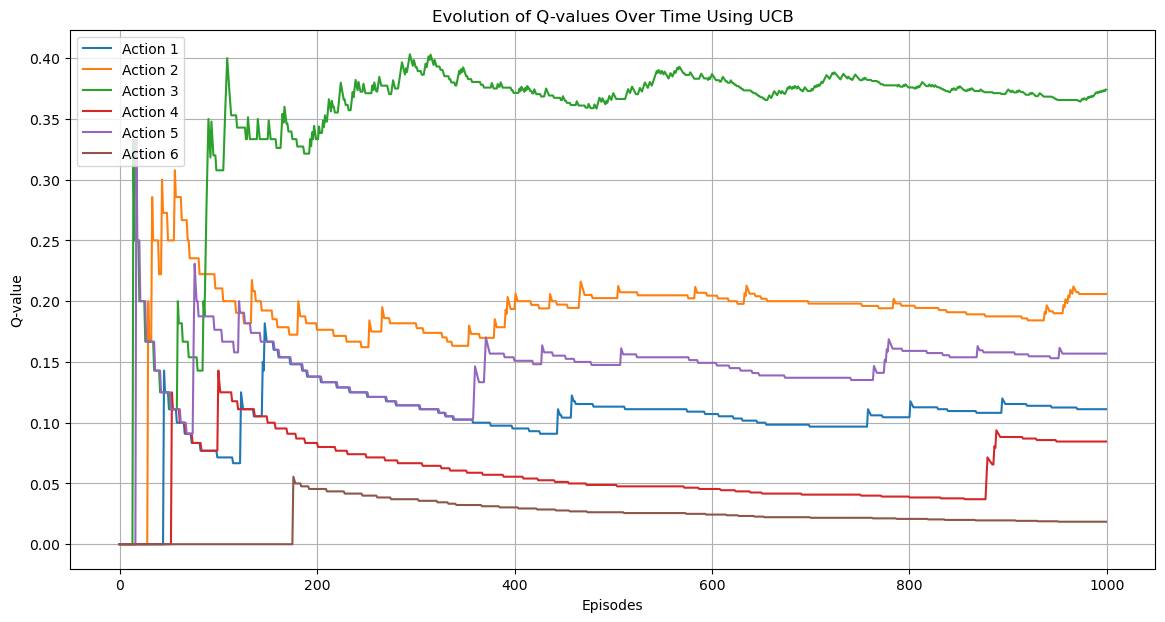

In [6]:
class BiasedDie:
    """Class to simulate a biased die roll."""
    def __init__(self, probabilities):
        self.probabilities = probabilities

    def roll(self):
        return np.random.choice([1, 2, 3, 4, 5, 6], p=self.probabilities)

class UCBGame:
    """Class to simulate a game using the Upper Confidence Bound (UCB) strategy."""
    def __init__(self, die, episodes=1000):
        self.die = die
        self.episodes = episodes
        self.action_estimates = np.zeros(6)  # Initial estimates for each action
        self.action_counts = np.zeros(6)
        self.estimate_history = np.zeros((episodes, 6))  # History for plotting

    def calculate_ucb(self, total_counts):
        """Calculate the UCB values for all actions."""
        return self.action_estimates + np.sqrt((2 * np.log(total_counts)) / self.action_counts)

    def run(self):
        for i in range(self.episodes):
            if np.min(self.action_counts) == 0:
                # Ensure each action is taken at least once
                action = np.argmin(self.action_counts)
            else:
                # Use UCB to select the next action
                total_counts = np.sum(self.action_counts)
                ucb_values = self.calculate_ucb(total_counts)
                action = np.argmax(ucb_values)
            
            # Roll the die and get the result
            result = self.die.roll()
            reward = 1 if (action + 1) == result else 0
            self.action_counts[action] += 1
            self.action_estimates[action] += (reward - self.action_estimates[action]) / self.action_counts[action]
            self.estimate_history[i] = self.action_estimates.copy()

        return self.action_estimates, self.estimate_history

    def plot_estimates(self):
        plt.figure(figsize=(14, 7))
        for action in range(6):
            plt.plot(self.estimate_history[:, action], label=f'Action {action+1}')
        plt.title('Evolution of Q-values Over Time Using UCB')
        plt.xlabel('Episodes')
        plt.ylabel('Q-value')
        plt.legend()
        plt.grid(True)
        plt.show()

# Create a biased die with specified probabilities
probabilities = [0.20, 0.20, 0.37, 0.05, 0.12, 0.06]
die = BiasedDie(probabilities)

# Initialize and run the UCB game simulation
ucb_game = UCBGame(die)
final_estimates, history = ucb_game.run()

# Plot the evolution of estimates
ucb_game.plot_estimates()

### همان گونه که از نمودار هر سه روش مشخص است . اکشن سوم که در واقع همان تاس شماره 3 است بالاترین امتیاز را کسب کرده است و در واقعیت هم همین طور است چون مقدار 3 در این تاس از بقیه مقادیر احتمال وقوع بالاتری دارد 